# Get started with Tomate

A little easily reproducible example to show some of Tomate features: loading data from a file, plotting it, doing some computations, and writing data to disk.
This is more a showcase than a proper tutorial, reading the [documentation](https://tomate.readthedocs.io) is always recommended :).

I am using the Sea Surface Temperature from this dataset https://podaac.jpl.nasa.gov/dataset/AMSRE_L3_SST_1DEG_1MO,
you can get the same file by running:

`wget https://podaac-opendap.jpl.nasa.gov/opendap/allData/modis/L3/aqua/11um/v2014.0/9km/monthly/2019/A20191822019212.L3m_MO_NSST_sst_9km.nc`

## Creating the database

We have a single NetCDF file, we can use `nc.scan_file` to create our database. For more realistic setups with multiple files, some more work
is necessary: see the [tutorial](https://tomate.readthedocs.io/en/latest/tutorial.html).

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from tomate.scan_library.nc import scan_file
db = scan_file("A20191822019212.L3m_MO_NSST_sst_9km.nc")

print(db)

Data object
Class: Data, Bases: DataDisk, DataCompute, DataPlot 

Variables:
palette [rgb, eightbitcolor] 
qual_sst (VariableMasked)  [lat, lon] 
sst (VariableMasked)  [lat, lon] 

Data available: 
Scope: available
var: palette, qual_sst, sst [3]
lat: -89.96 - 89.96 [2160]
lon: -179.96 - 179.96 [4320]
rgb: 0.00 - 2.00 [3]
eightbitcolor: 0.00 - 255.00 [256]

Data not loaded

No data selected

1 Filegroups:
	: palette, qual_sst, sst


This has printed some information about the database: the type of database, the variables object available, and what part of the data is available, loaded or selected.

We also have access to data and variables attributes through the VariablesInfo object (or VI):

In [2]:
print(db.vi, '\n')

print(db.vi.date_created)
print(db.vi['sst'].units)

Variables: palette, qual_sst, sst
Attributes: display_scale, display_min, display_max, long_name, scale_factor, _FillValue, valid_min, standard_name, _var_class, add_offset, datatype, valid_max, units
Infos: product_name, instrument, title, project, platform, temporal_range, processing_version, date_created, history, l2_flag_names, time_coverage_start, time_coverage_end, start_orbit_number, end_orbit_number, map_projection, latitude_units, longitude_units, northernmost_latitude, southernmost_latitude, westernmost_longitude, easternmost_longitude, geospatial_lat_max, geospatial_lat_min, geospatial_lon_max, geospatial_lon_min, latitude_step, longitude_step, sw_point_latitude, sw_point_longitude, geospatial_lon_resolution, geospatial_lat_resolution, geospatial_lat_units, geospatial_lon_units, spatialResolution, number_of_lines, number_of_columns, measure, suggested_image_scaling_minimum, suggested_image_scaling_maximum, suggested_image_scaling_type, suggested_image_scaling_applied, _lastM

## Loading and plotting some data

Now we load everything from the file. We then plot the variable 'sst'.

In [3]:
db.load()

INFO:tomate:Allocating [3, 256] of type |u1 for palette
INFO:tomate:Allocating [2160, 4320] of type |u1 for qual_sst
INFO:tomate:Allocating [2160, 4320] of type <f4 for sst
INFO:tomate:Opening A20191822019212.L3m_MO_NSST_sst_9km.nc
INFO:tomate:Taking keys [0:3, 0:256] from variable palette
INFO:tomate:Placing it in palette, [0:3, 0:256]
INFO:tomate:Taking keys [2159::-1, 0:4320] from variable qual_sst
INFO:tomate:Placing it in qual_sst, [0:2160, 0:4320]
INFO:tomate:Taking keys [2159::-1, 0:4320] from variable sst
INFO:tomate:Placing it in sst, [0:2160, 0:4320]


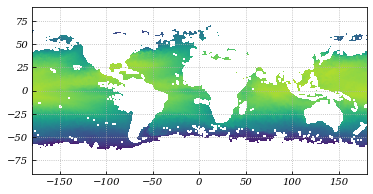

In [4]:
fig, ax = plt.subplots()
im = db.imshow(ax, 'sst')

We reload only a subpart of the data from the file, with longitudes ranging from 60W to 10E, and latitudes from 50S to 50N.
Note this discard and replaces the data previously loaded.
Again, we plot what we just loaded.

In [5]:
db.load_by_value(lon=slice(-60, 10), lat=slice(-50, 50))

INFO:tomate:Allocating [3, 256] of type |u1 for palette
INFO:tomate:Allocating [1202, 842] of type |u1 for qual_sst
INFO:tomate:Allocating [1202, 842] of type <f4 for sst
INFO:tomate:Opening A20191822019212.L3m_MO_NSST_sst_9km.nc
INFO:tomate:Taking keys [0:3, 0:256] from variable palette
INFO:tomate:Placing it in palette, [0:3, 0:256]
INFO:tomate:Taking keys [1680:478:-1, 1439:2281] from variable qual_sst
INFO:tomate:Placing it in qual_sst, [0:1202, 0:842]
INFO:tomate:Taking keys [1680:478:-1, 1439:2281] from variable sst
INFO:tomate:Placing it in sst, [0:1202, 0:842]


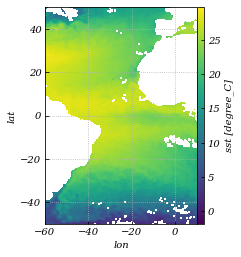

In [6]:
fig, ax = plt.subplots()

im = db.imshow(ax, 'sst')
im.add_colorbar()
im.set_labels()

Let's compute the mean of the variable 'sst' over a small region. For that, we need to find the indices corresponding to that region. The `subset` function will find all indices between two values.

In [7]:
lat_slice = db.loaded.lat.subset(-30., -15.)
lon_slice = db.loaded.lon.subset(8., 25.)
mean = db.mean('sst', dims=['lon', 'lat'], lat=lat_slice, lon=lon_slice)

print(mean)

18.433271


We can also directly plot an averaged variable, let's plot the meridional average of the SST. This is very useful for Hovmöller plots (for those use `imshow_avg`)!

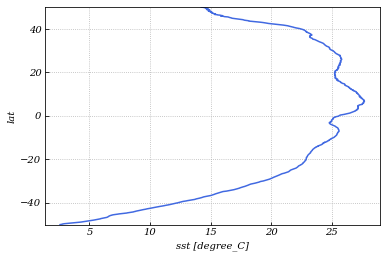

In [8]:
fig, ax = plt.subplots()

line = db.plot_avg(ax, 'sst', avg_dims=['lon'], axes=['sst', 'lat'])
line.set_labels()

## Viewing data

Once loaded, the data array is directly accessible for each variable as:

In [9]:
sst = db['sst'].data
sst = db['sst'][:]

But you can also retrieve parts of the data using the `view` function, from a variable, or the database object itself (to retrieve different variables at once).

In [10]:
sst = db['sst'].view(lat=slice(0, 10), lon=slice(0, 40, 2))
print(sst.shape)

sst = db.view(var='sst', lat=slice(0, 10), lon=slice(0, 40, 2))
print(sst.shape)

array = db.view(var=['sst', 'qual_sst'], lat=slice(0, 10), lon=slice(0, 40, 2),
                stack='force')
print(array.shape)

(10, 20)
(10, 20)
(2, 10, 20)


`view_by_value` does the same thing, but select by value and not index.

In [11]:
sst = db.view_by_value('sst', lat=slice(-10, 10), lon=[-40, -35, -30, -25])
print(sst.shape)

(242, 4)


## Selecting data

You can similarly select data, eventually change the selection and use it in some functions.

In [12]:
# Do the selection
db.select(var='sst', lat=slice(0, 100))

# Reduce the selection
db.selected.slice(lon=slice(0, 50))

# Expand the selection
db.add_to_selection(var='qual_sst')

# Use the selection
sst = db.view_selected(var='sst')
print(sst.shape)

(100, 50)


Again, we can select by value. Note that `*_by_value` functions can receive value.s, ranges of values, **and** indices by  appending `_idx` to the name of the dimension.

In [13]:
db.select_by_value(var='sst', lat=slice(-50., -41.8), lon_idx=slice(0, 50))
print(db.view_selected().shape)

(100, 50)


## Adding variables

Let's add another variable. This will just be the SST with different units.

In [14]:
from tomate.var_types import VariableMasked

db.add_variable('sst_k', dims=['lat', 'lon'], var_class=VariableMasked, attrs={'units': 'degree_K'})

db['sst_k'] = db['sst'][:] + 273.15

INFO:tomate:Allocating [1202, 842] of type None for sst_k


## Writing to disk

We can now write our new variable to disk (along with old variable).
We need first to add some information for this new variable to the `Filegroup` object, which takes care of data loading and writing.

In [15]:
db.filegroups[0].add_variable('sst_k')
db.write('new_file.nc', file_kw={'clobber': True})

INFO:tomate:Opening new_file.nc
INFO:tomate:Laying eightbitcolor values, extent 0.00 - 255.00
INFO:tomate:Laying rgb values, extent 0.00 - 2.00
INFO:tomate:Laying lat values, extent -50.04 - 50.04
INFO:tomate:Laying lon values, extent -60.04 - 10.04
INFO:tomate:Inserting variable palette
INFO:tomate:Taking keys from palette: [:, :]
INFO:tomate:Placing it in file at [:, :].
INFO:tomate:Inserting variable qual_sst
INFO:tomate:Taking keys from qual_sst: [:, :]
INFO:tomate:Placing it in file at [:, :].
INFO:tomate:Inserting variable sst
INFO:tomate:Taking keys from sst: [:, :]
INFO:tomate:Placing it in file at [:, :].
INFO:tomate:Inserting variable sst_k
INFO:tomate:Taking keys from sst_k: [:, :]
INFO:tomate:Placing it in file at [:, :].


[`db.write_add_variable`](https://tomate.readthedocs.io/en/latest/_references/tomate.db_types.data_disk.html#tomate.db_types.data_disk.DataDisk.write_add_variable) is also very useful to add a variables to existing files. To use with caution though.

## Conclusion

Be sure to check the documentation for the functions we used in the [API](https://tomate.readthedocs.io/en/latest/_references/tomate.html), there are interesting options I haven't discussed here.

The rest of the [documentation](https://tomate.readthedocs.io) is great too !